# Autonomous and Adaptive Systems Project

In [ ]:
!pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

from stable_baselines3.common.vec_env import SubprocVecEnv
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

from experience_manager_parallel import ExperienceDict
from utilities import *
from plot_and_save_parallel import LearningInfo
from model import ImpalaModel

from tqdm import tqdm
import warnings

# Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Constants and Paths

In [2]:
# training parameters
NUM_LEVELS_TRAIN = 200
NUM_ENVS = 16
EPOCHS = 3
BATCH_SIZE = 256*NUM_ENVS
MINIBATCHES_PER_EPOCH = 8
MINIBATCH_SIZE = BATCH_SIZE//MINIBATCHES_PER_EPOCH
MAX_TIMESTEPS_TRAIN = 3000000

# hyperparameters
FRUITBOT_LEARNING_RATE = 5e-4
COINRUN_LEARNING_RATE = 1e-4
CLIP_RATIO = 0.2
C1 = 0.5                     # critic weight in the total loss
C2 = 0.01                    # entropy weight in the total loss
GAMMA = 0.999                # discount factor
LAMBDA = 0.95                # bias-variance trade-off parameter for GAE

# test parameters
MAX_TIMESTEPS_TEST = 100000
NUM_LEVELS_TEST = 0

# seed settings
SEED = 11
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# paths
PLOT_PATH_TRAIN = "plots_train"
PLOT_PATH_TEST = "plots_test"
WEIGHTS_PATH = "weights"
WEIGHTS_FILE_NAME = "model_weights.pt"

# print settings
VERBOSE = False
PLOT_LOSSES = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training Function

Given a game name and a learning rate, this function performs the full training pipeline, at the end of which it returns the trained model and the training information.

In [3]:
def train(game, learning_rate):
    plot_path = os.path.join(PLOT_PATH_TRAIN, game)
    weight_path = os.path.join(WEIGHTS_PATH, game)
    check_paths([plot_path, weight_path])

    # environments creation
    envs = SubprocVecEnv([make_env(game, SEED, NUM_LEVELS_TRAIN) for _ in range(NUM_ENVS)])
    
    # actor and critic variables setup
    actor_critic_model = ImpalaModel().to(DEVICE)
    actor_critic_optimizer = optim.Adam(actor_critic_model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()
    
    # support for learning and information storing
    trajectory_dict = ExperienceDict(batch_size=BATCH_SIZE, minibatch_size=MINIBATCH_SIZE, n_envs=NUM_ENVS)
    learning_info = LearningInfo(timestep_to_plot=MAX_TIMESTEPS_TRAIN,
                                 plot_save_path=plot_path,
                                 n_env=NUM_ENVS,
                                 game=game)
    
    total_timesteps = 0
    obs = envs.reset()

    # variable containing the number of episodes for each environment updated in real-time
    n_episodes = np.zeros(NUM_ENVS, dtype=int)

    # loop until MAX_TIMESTEPS is reached
    with tqdm(total=MAX_TIMESTEPS_TRAIN) as pbar:
        while total_timesteps < MAX_TIMESTEPS_TRAIN:
            actions, action_probs, values = compute_action_value_parallel(actor_critic_model, obs, DEVICE)

            next_obs, rewards, done, _ = envs.step(actions)
            total_timesteps += NUM_ENVS
            pbar.update(NUM_ENVS)

            if any(done):
                done_envs_idx = [index for index, value in enumerate(done) if value]
                n_episodes[done_envs_idx] += 1

            # training information and trajectory update
            learning_info.update(total_timesteps, n_episodes, rewards, verbose=False)
            trajectory_dict.appendTrajectory(state=obs,
                                             action=actions,
                                             action_prob=action_probs,
                                             reward=rewards,
                                             value=values,
                                             done=done)
            obs = next_obs

            # When the trajectory_dict collected a number BATCH_SIZE of trajectories the weights of the model are updated
            if trajectory_dict.is_full():

                # compute the next value for the GAE computation
                with torch.no_grad():
                    _, next_values = actor_critic_model(torch.tensor(obs).to(DEVICE))

                # Retrieve shuffled data stored during the previous loops
                dataloader = trajectory_dict.get_batches(td_gamma=GAMMA,
                                                         gae_lambda=LAMBDA,
                                                         next_values=next_values,
                                                         device=DEVICE,
                                                         shuffle=True)

                for _ in range(EPOCHS):
                    for states, actions, old_action_probs, advantages, returns in dataloader:
                        current_action_dist, values = actor_critic_model(states)
                        current_action_probs = current_action_dist.gather(dim=1, index=actions.unsqueeze(-1).to(torch.int64)).squeeze(-1)

                        prob_ratio = torch.exp(torch.log(current_action_probs) - torch.log(old_action_probs))
                        clipped_ratio = torch.clamp(prob_ratio, 1 - CLIP_RATIO, 1 + CLIP_RATIO)

                        actor_loss = -torch.min(prob_ratio * advantages, clipped_ratio * advantages).mean()

                        critic_loss = mse_loss(values.squeeze(-1), returns)

                        entropy = -(current_action_dist * torch.log(current_action_dist + 1e-10)).mean()

                        total_loss = actor_loss + (C1 * critic_loss) - (C2 * entropy)
                        actor_critic_optimizer.zero_grad()
                        total_loss.backward()
                        actor_critic_optimizer.step()

                # At the end of training, update the folder with the old weights and reset the trajectory dict
                trajectory_dict.clear()
                learning_info.save_weights(model=actor_critic_model, weights_path=weight_path, file_name=WEIGHTS_FILE_NAME)
    
    envs.close()
    
    learning_info.plot_metrics(verbose=True)
    return actor_critic_model, learning_info

## Validate Function

Given a game name, this function creates an environment and tests the performance of an agent on that game. If a model is provided, its performance is monitored; otherwise, a random agent is used for validation. This function returns the information regarding the performance of the agent.

In [3]:
def validate(game, model=None):
    plot_path = os.path.join(PLOT_PATH_TEST, game)
    check_paths([plot_path])

    # environment creation
    env = SubprocVecEnv([make_env(game, SEED+1, NUM_LEVELS_TEST)])

    learning_info = LearningInfo(timestep_to_plot=MAX_TIMESTEPS_TEST,
                                plot_save_path=plot_path,
                                n_env=1,
                                game=game)
    
    total_timesteps = 0
    obs = env.reset()

    # number of episodes for each environment
    n_episodes = 0

    # loop until MAX_TIMESTEPS_TEST is reached (default value is 100k)
    with tqdm(total=MAX_TIMESTEPS_TEST) as pbar:
        while total_timesteps < MAX_TIMESTEPS_TEST:
            if model:
                action, _, _ = compute_action_value_parallel(model, obs, "cpu")
            else:
                action = np.random.randint(15)
    
            next_obs, rewards, done, _ = env.step([action])
            total_timesteps += 1
            pbar.update(1)
            if done:
                n_episodes += 1
            
            learning_info.update(total_timesteps, [n_episodes], rewards, verbose=False)
            obs = next_obs
    
        env.close()
    
    return learning_info

## Fruitbot

Fruitbot is a scrolling game where a robot must navigate between gaps in walls and collect fruit along the way. The player receives a positive reward for collecting a piece of fruit and a larger negative reward for mistakenly collecting a non-fruit object. At the end of the level, a big reward is given. The best performance is achieved when the agent obtains a high reward over a longer time. The theoretical bound representing the maximum sum of rewards within an episode is 32.4

### Training

100%|██████████| 3000000/3000000 [1:51:06<00:00, 450.00it/s]  


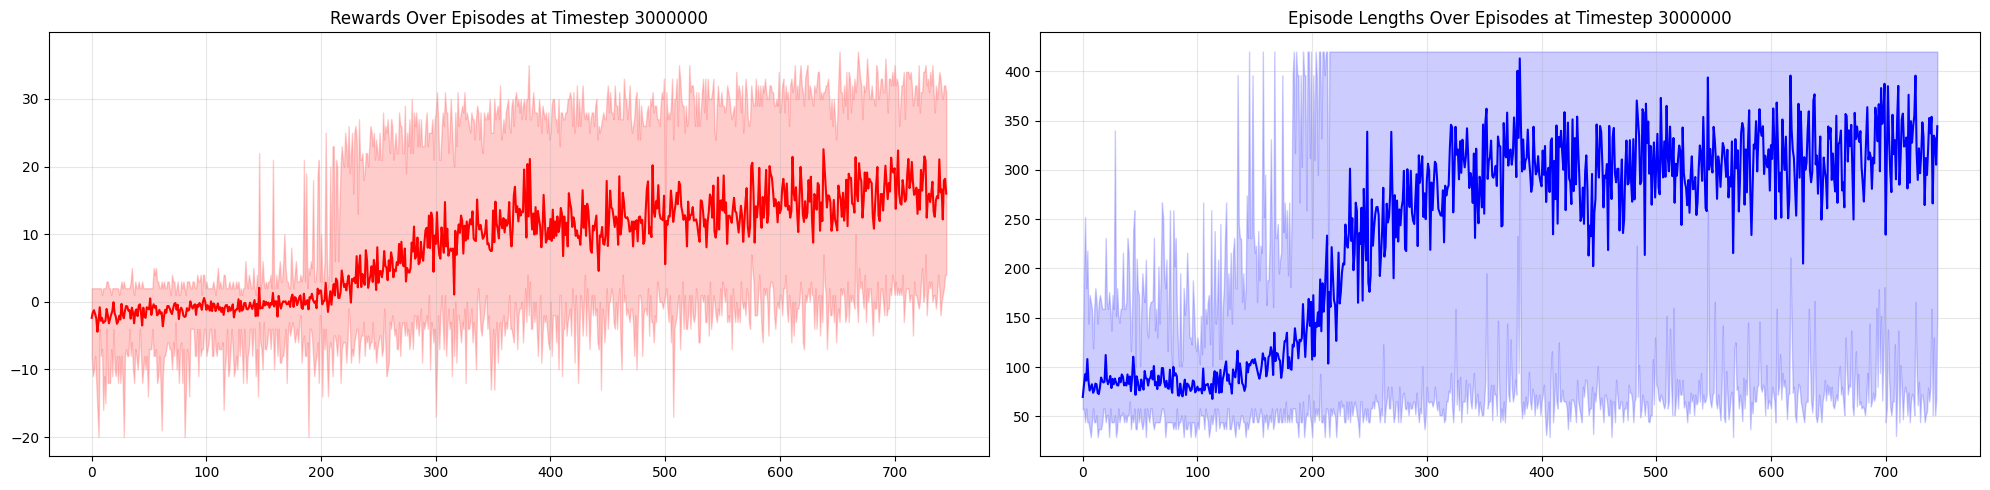

- Total episodes: 746

Performance during first 5.0% of episodes
- Average reward per episode: -1.98 		 Standard deviation: 0.93
- Average episode length: 84.57 		 Standard deviation: 8.20

Performance during last 5.0% of episodes
- Average reward per episode: 16.61 		 Standard deviation: 2.45
- Average episode length: 326.27 		 Standard deviation: 30.58


In [5]:
GAME = "fruitbot"

fruitbot_model, fruitbot_training_info = train(GAME, FRUITBOT_LEARNING_RATE)
fruitbot_training_info.summary("train", percentage=0.05)

### Performance on the Test Set

In [5]:
fruitbot_validate_info = validate(GAME, fruitbot_model)
fruitbot_validate_info.summary("test")

100%|██████████| 100000/100000 [18:46<00:00, 88.75it/s]

- Total episodes: 311
- Average reward per episode: 16.15 		 Standard deviation: 10.74
- Average episode length: 320.68 		 Standard deviation: 127.73


### Random Agent Scores

In [38]:
fruitbot_random_agent_info = validate(GAME)
fruitbot_random_agent_info.summary("test")

100%|██████████| 100000/100000 [06:54<00:00, 241.12it/s]

- Total episodes: 1214
- Average reward per episode: -2.54 		 Standard deviation: 3.93
- Average episode length: 82.33 		 Standard deviation: 34.06


## Coinrun

Coinrun is a simple platformer where the goal is to collect the coin at the far right of the level, with the player starting on the far left. The player must dodge stationary saw obstacles, enemies that pace back and forth, and chasms that lead to death. The best performance is achieved when the agent obtains a high reward in a short time. The maximum sum of rewards within an episode is 10

### Training

100%|██████████| 3000000/3000000 [1:57:15<00:00, 426.43it/s]  


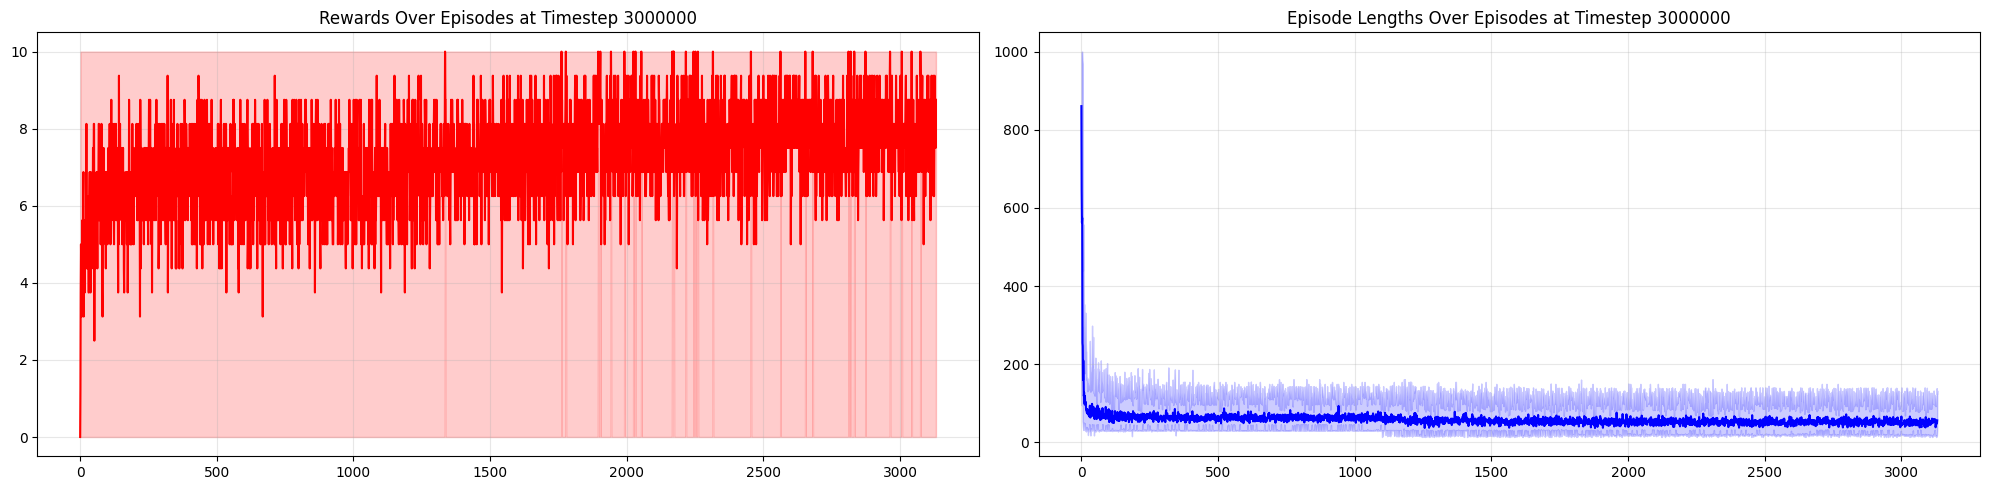

- Total episodes: 3132

Performance during first 5.0% of episodes
- Average reward per episode: 5.93 		 Standard deviation: 1.40
- Average episode length: 92.47 		 Standard deviation: 98.14

Performance during last 5.0% of episodes
- Average reward per episode: 7.82 		 Standard deviation: 0.97
- Average episode length: 50.94 		 Standard deviation: 6.15


In [5]:
GAME = "coinrun"

coinrun_model, coinrun_training_info = train(GAME, COINRUN_LEARNING_RATE)
coinrun_training_info.summary("train", percentage=0.05)

### Performance on the Test Set

In [7]:
coinrun_validate_info = validate(GAME, coinrun_model)
coinrun_validate_info.summary("test")

100%|██████████| 100000/100000 [15:27<00:00, 107.78it/s]

- Total episodes: 1811
- Average reward per episode: 6.83 		 Standard deviation: 4.65
- Average episode length: 55.18 		 Standard deviation: 25.94


### Random Agent Scores

In [8]:
coinrun_random_agent_info = validate(GAME)
coinrun_random_agent_info.summary("test")

100%|██████████| 100000/100000 [09:32<00:00, 174.62it/s]

- Total episodes: 156
- Average reward per episode: 2.44 		 Standard deviation: 4.29
- Average episode length: 638.69 		 Standard deviation: 361.58
